In [1]:
%load_ext autoreload
%autoreload 3
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from waveform_simplified import tophat_fd_waveform, get_snrs_theoretical
import jax
import priors
from confusion_noise import get_threshold_and_conf_noise_for_powerlaw
import matplotlib.pyplot as plt


plt.rcParams.update({
    # LaTeX rendering
    'text.usetex': True,
    'font.family': 'serif',
    'font.serif': ['Computer Modern Roman'],
    'text.latex.preamble': r'\usepackage{amsmath}',
    'pgf.texsystem': 'pdflatex',
    
    # Figure
    'figure.facecolor': 'white',
    'figure.edgecolor': 'white',
    
    # Axes
    'axes.facecolor': 'white',
    'axes.edgecolor': 'black',
    'axes.linewidth': 1.5,
    'axes.labelsize': 20,
    'axes.titlesize': 24,
    
    # Ticks - inward pointing, on all sides
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    'xtick.major.size': 8,
    'ytick.major.size': 8,
    'xtick.minor.size': 4,
    'ytick.minor.size': 4,
    'xtick.major.width': 1.5,
    'ytick.major.width': 1.5,
    'xtick.minor.width': 1.0,
    'ytick.minor.width': 1.0,
    'xtick.top': True,
    'ytick.right': True,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    
    # Lines
    'lines.linewidth': 2,
    'lines.markersize': 8,
    
    # Legend
    'legend.frameon': False,
    'legend.fontsize': 11,
    
    # Grid off
    'axes.grid': False,
})

In [2]:
import shutil
print(shutil.which('latex'))
print(shutil.which('pdflatex'))

/Library/TeX/texbin/latex
/Library/TeX/texbin/pdflatex


mu (sources per bin) 15.555555555555554
2.7006172839506172e-11
2334


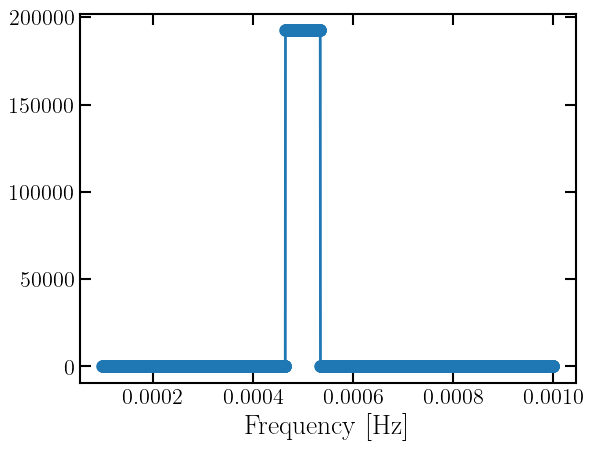

In [3]:
Tobs = 86400 * 30
flow = 1e-4
fhigh = 1e-3
df = 1 / Tobs 

# rho cutoff
rho_th = 5

# number of sources
N_sources = 200

# spectral index and low
# cutoff on amplitude distribution
alpha = 4
A_lower = 1e-3



# one sided PSD level of the noise
psd_level = 2.111

# width in frequency space
w = .7e-4

mu = N_sources * w / (fhigh - flow)
print('mu (sources per bin)', mu)
# corresponding "fdot" for a linear chirp
fdot = w / Tobs
print(fdot)

frequencies = np.arange(flow, fhigh + df, df)
Nbins = frequencies.size
print(Nbins)


# our waveforms will be just postive frequencies \tilde h(f). 
# so take 1-sided to 2-sided PSD, split variance between real and imaginary.
# that gives us a factor of 4.
fake_noise_fd = (np.random.randn(Nbins) + 1j * np.random.randn(Nbins)) * np.sqrt(psd_level * Tobs / 4)

plt.plot(frequencies, jnp.abs(tophat_fd_waveform(1, 5e-4, 0, fdot, frequencies)), '-o')
plt.xlabel("Frequency [Hz]")
plt.savefig("plots/example_waveform.pdf")
plt.show()

In [4]:
# jit
tophat_fd_waveform_jit = jax.jit(tophat_fd_waveform, static_argnames=('fdot'))

# leave fdot and frequencies constant, vmap over amplitudes, central frequency, and
# central phase
vmap_tophat_fd_waveform = jax.vmap(tophat_fd_waveform_jit, in_axes=[0, 0, 0, None, None])

In [5]:
fcenters = np.random.rand(N_sources) * (fhigh - flow) + (flow)
Amplitudes = priors.sample_power_law_bounded(4, A_lower, 10, N_sources)
phi_centers = np.random.rand(N_sources) * 2 * jnp.pi

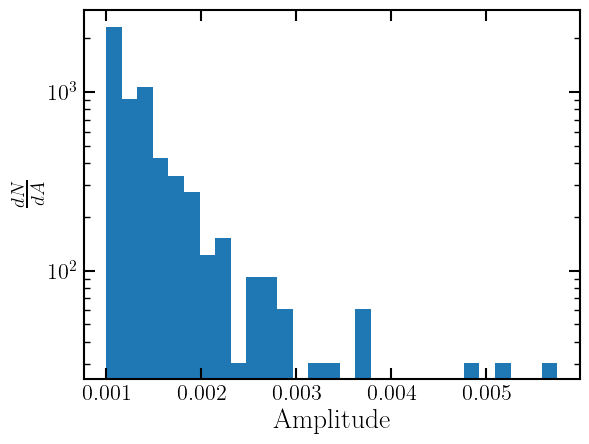

In [6]:
plt.hist(Amplitudes, density=True, bins='auto')
ax = plt.gca()
plt.xlabel("Amplitude")
plt.ylabel("$\\frac{dN}{dA}$")
# ax.axvline(Ath)
plt.yscale("log")
plt.savefig("plots/amplitude_distribution.pdf")
plt.show()

In [7]:
fake_signals = jnp.sum(vmap_tophat_fd_waveform(Amplitudes, fcenters, phi_centers, fdot, jnp.array(frequencies)), axis=0)

In [8]:
Ath, Sconf, var_Sconf = get_threshold_and_conf_noise_for_powerlaw(Tobs, fhigh - flow, psd_level, N_sources, alpha, 5, A_lower, w)

In [9]:
print(2 * np.mean(np.abs(fake_signals[10:-10])**2 / Tobs))
print(Sconf)

1.1719557
0.8328893335350748


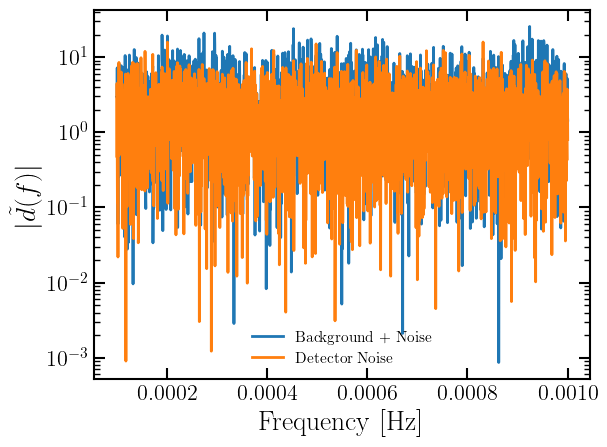

In [10]:
plt.plot(frequencies, 2 * jnp.abs(fake_signals + fake_noise_fd)**2 / Tobs, label='Background + Noise')
plt.plot(frequencies, 2 * jnp.abs(fake_noise_fd)**2 / Tobs, label='Detector Noise')
plt.xlabel("Frequency [Hz]")
plt.ylabel("$|\\tilde d(f)|$")
ax = plt.gca()

plt.yscale("log")
plt.legend()
plt.savefig("plots/simulatd_frequency_domain_data.pdf")
plt.show()

In [11]:
from scipy.stats import poisson

In [12]:
# Fake sources
from tqdm import tqdm
Sconfs = []
measureds = []
rhos = []
correlations = []
# make them small such that none are above threshold
# A_lower = 1e-3
# N_sources = 100
for ii in tqdm(range(5000)):

    # poisson on actual number
    Ns = poisson.rvs(N_sources)

    # central frequencies...draw from the full band
    fcenters = np.random.rand(Ns) * (fhigh - flow) + (flow) # move away from the edges

    # simulate Amplitudes and phases
    Amplitudes = priors.sample_power_law_bounded(4, A_lower, 10, Ns)
    phi_centers = np.random.rand(Ns) * 2 * jnp.pi

    # Use the mean to get the threshold for confusion noise
    Ath, Sconf, var_Sconf = get_threshold_and_conf_noise_for_powerlaw(Tobs, fhigh - flow, psd_level, N_sources, alpha, rho_th, A_lower, 0)

    # a bit of a circular test here...but it's giving consistent results
    # need to calculate the cutoff...do decide which waveforms to cut. 
    # can't just calculate SNR w.r.t. detector noise.
    rhos.append(2 * Amplitudes / np.sqrt(Sconf + psd_level) * jnp.sqrt(Tobs))

    # simulate signals generated from the background
    # this step will mean recompiling the code for each array size (annoying)
    # so it will result in some strange evaluation times.
    fake_signals = jnp.sum(vmap_tophat_fd_waveform(Amplitudes[Amplitudes < Ath], fcenters[Amplitudes<Ath], phi_centers[Amplitudes < Ath], fdot, jnp.array(frequencies)), axis=0)


    # Calculate correlations between bins
    xi = np.fft.ifft(np.abs(np.fft.fft(fake_signals))**2).real
    xi = xi / xi[0]  # normalize
    correlations.append(xi)

    # only consider cases where full signals are contributing
    # So we're shrinking our band here a bit, but we've simulated
    # signals outside of it that still contriubte to our band. 
    # this then gives a self-consistent result.
    measureds.append(fake_signals[int(w/2 * Tobs):-int(w/2 * Tobs)])
    
    Sconfs.append(Sconf)

simulated_power_spectra = np.array(2 * np.abs(measureds)**2 / Tobs)


# will all be the same for fixed N_sources injected
Sconfs = jnp.array(Sconfs)

# Complex correlation vs lag
signals = np.array(measureds)
max_lag = int(3 * w * Tobs)
xi_complex = np.zeros(max_lag, dtype=complex)
for lag in range(max_lag):
    xi_complex[lag] = np.mean(signals[:, :-max_lag] * np.conj(signals[:, lag:lag-max_lag or None]))

# Normalize by zero-lag
xi_complex /= xi_complex[0]


100%|██████████| 5000/5000 [00:10<00:00, 461.46it/s]


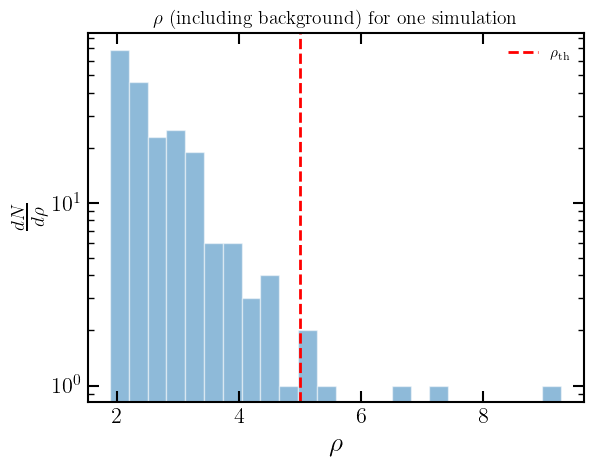

In [13]:
plt.title("$\\rho$ (including background) for one simulation", fontsize=14)
plt.hist(rhos[0], edgecolor='w', bins='auto', alpha=0.5)
# plt.hist(rhos[1], edgecolor='w', bins='auto', alpha=0.5)
plt.xlabel("$\\rho$")
plt.ylabel("$\\frac{dN}{d\\rho}$")
ax = plt.gca()
ax.axvline(rho_th, ls='--', color='r', label='$\\rho_{\\rm th}$')
plt.legend()
plt.yscale("log")
plt.show()

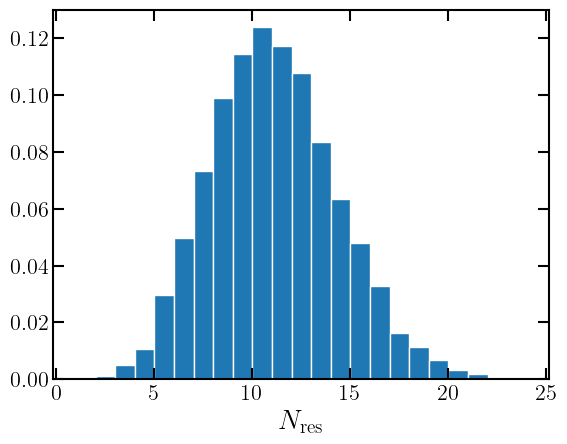

In [14]:
# number of resolvable sources
plt.hist([np.sum(r > rho_th) for r in rhos], bins='auto', density=True, edgecolor='w')
plt.xlabel("$N_{\\rm res}$")
plt.show()

# Look at distribution of S_B as a function of simulations

For 1000 sources in the band, and each source taking up ~10% of the band
we see significant variability in the mean background strength across the band. 
That's true even for a given choice of hyperparameters. So we will likely need to
marginalize over this in our likelihood. We can calculate analytically the spread.

Note that this plot below is calculated by:

1. Simulate sources whose rho < rho_th. Note that rho_th requires our analytic estimate of S_B (mean)
2. For each simulation, take the simulated power spectrum across the band, and take a mean across frequency bins.
3. Repeat. So we get 5,000 S_B values that are the mean across the spectrum

The variance of this quantity is given by

$$\mathrm{var}(S_B^{avg}) = \frac{4 N_{\mathrm tot}}{B^2} \langle A^4 \rangle$$

If we consider the variance for the power in a single bin (that is, we are not averaging across bins) we find:

$$\mathrm{var}(S_B^{\mathrm bin}) = \frac{4 N_{\mathrm tot}}{B} \langle A^4 \rangle$$

And to recover the band-averaged quantity we consider the effective number of bins we average across, which is given by $B/w$. 

The variances come from consider the second moment of a compound poisson process. 

0.99816835


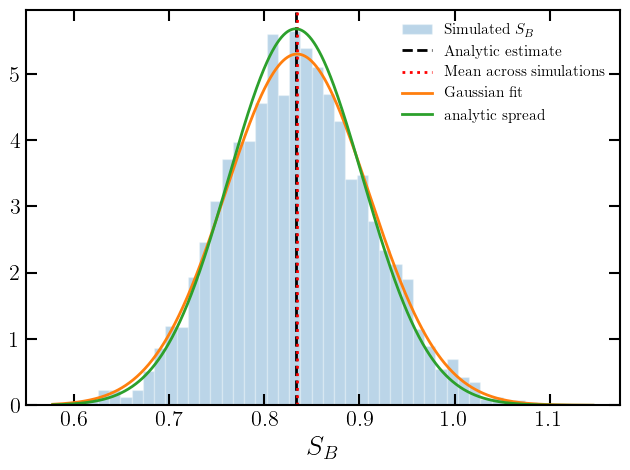

In [19]:


from scipy.stats import norm
S_band_averaged_simulations = np.mean(simulated_power_spectra, axis=1)
plt.hist(S_band_averaged_simulations, bins='auto', density=True, alpha=0.3, edgecolor='w', label='Simulated $S_B$')
ax = plt.gca()
ax.axvline(Sconfs[0], c='k', ls='--', label='Analytic estimate')
ax.axvline(np.mean(S_band_averaged_simulations), c='r', ls=':', label='Mean across simulations')

print(Sconfs[0] / np.mean(S_band_averaged_simulations))
plt.xlabel("$S_{B}$")
# plt.yscale("log")
plt.plot(np.linspace(min(S_band_averaged_simulations), max(S_band_averaged_simulations), num=1000),
         norm.pdf(np.linspace(min(S_band_averaged_simulations), max(S_band_averaged_simulations), num=1000),
                  loc=np.mean(S_band_averaged_simulations), scale=np.std(S_band_averaged_simulations)),
         label='Gaussian fit')
plt.plot(np.linspace(min(S_band_averaged_simulations), max(S_band_averaged_simulations), num=1000), norm.pdf(np.linspace(min(S_band_averaged_simulations), max(S_band_averaged_simulations), num=1000), loc=Sconfs[0], scale=np.sqrt(var_Sconf)),
         label='analytic spread')
plt.legend()
plt.tight_layout()
plt.savefig("plots/sb_simulations.pdf")
plt.show()

# Gaussianity tests
Look at distribution of power in each frequency bin bin over many simulations, if it is an exponential disribution, that is consistent with Gaussian in the real and imaginary. 

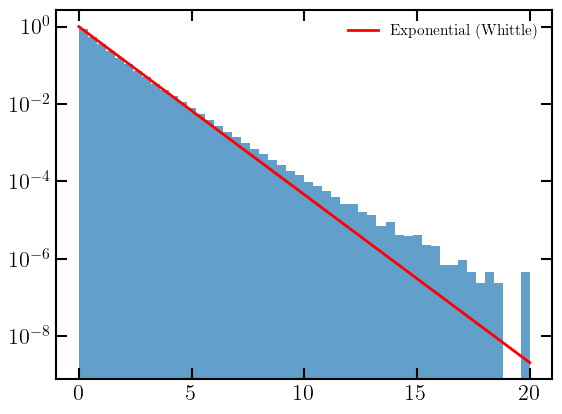

In [20]:

plt.hist(simulated_power_spectra.flatten() / np.mean(simulated_power_spectra), bins=50, density=True, alpha=0.7)
x = np.logspace(-4, np.log10(np.max(simulated_power_spectra.flatten() / np.mean(simulated_power_spectra))), 100)
plt.plot(x, np.exp(-x), 'r-', label='Exponential (Whittle)')
plt.yscale("log")
# plt.xscale("log")
plt.legend()

In [21]:
kurtosis_ratio = np.mean(simulated_power_spectra.flatten()**2) / np.mean(simulated_power_spectra)**2
print(f"Kurtosis ratio (expect 2 for Whittle): {kurtosis_ratio:.2f}")

Kurtosis ratio (expect 2 for Whittle): 2.09


# Correlations between bins

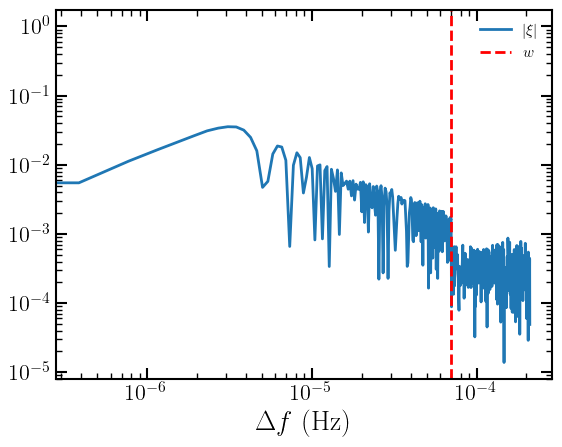

In [ ]:


plt.plot(np.arange(max_lag) / Tobs, np.abs(xi_complex), label=r'$|\xi|$')

plt.axvline(w, color='r', ls='--', label='$w$')
plt.xscale("log")
plt.xlabel(r'$\Delta f$ (Hz)')
plt.yscale("log")
plt.legend()